In [89]:
import pandas as pd
import geopandas as gpd
import numpy as np
from skgstat import Variogram, SpaceTimeVariogram
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gstools as gs

In [2]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)
gdf = gdf[gdf.Basin_Numb == "5-021"]

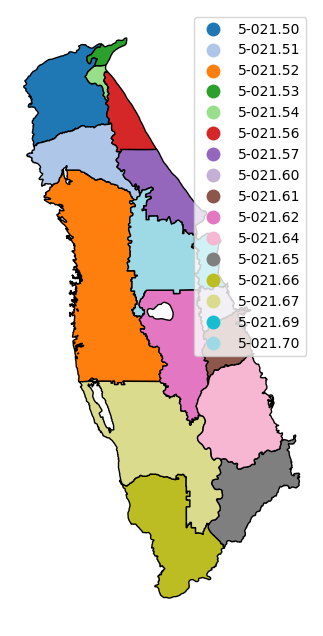

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))
plot = gdf.plot(ax=ax,
                column='Basin_Subb',
                cmap='tab20',
                edgecolor='black',
                legend=True)

ax.set_axis_off()
plt.show()

### For 0-15m Coarse Fraction

In [11]:
v2_full = pd.read_csv("GA-sklearn/v2_full_grid.csv")
v2_full = gpd.GeoDataFrame(v2_full, geometry=gpd.points_from_xy(v2_full.longitude, v2_full.latitude))
v2_full.set_crs(epsg=4326, inplace=True)
v2_full.loc[(v2_full['pred'] < 0) | (v2_full['pred'] > 100), 'pred'] = np.nan

In [28]:
v2_full = v2_full.to_crs(gdf.crs)
v2_full_with_basins = gpd.sjoin(v2_full, gdf[['Basin_Subb', 'geometry']],
                                how='left', predicate='intersects')
v2_full_with_basins = v2_full_with_basins.drop(columns='OBJECTID')
v2_full_with_basins = v2_full_with_basins[~v2_full_with_basins.Basin_Subb.isna()]
v2_full_with_basins = v2_full_with_basins[~v2_full_with_basins.pred.isna()]

In [34]:
v2_full_with_basins_projected = v2_full_with_basins.to_crs("EPSG:3310")
grouped = v2_full_with_basins_projected.groupby('Basin_Subb')
variograms_dict = {}

for subb, gdf_group in tqdm(grouped):
    coords = np.column_stack((gdf_group.geometry.x, gdf_group.geometry.y))
    values = gdf_group['pred'].to_numpy()
    V = Variogram(
        coordinates=coords,
        values=values,
        # model='spherical',
        # bin_func='equal', 
        # n_lags=10,
        # maxlag='median',
    )
    variograms_dict[subb] = V

100%|██████████| 16/16 [00:03<00:00,  4.40it/s]


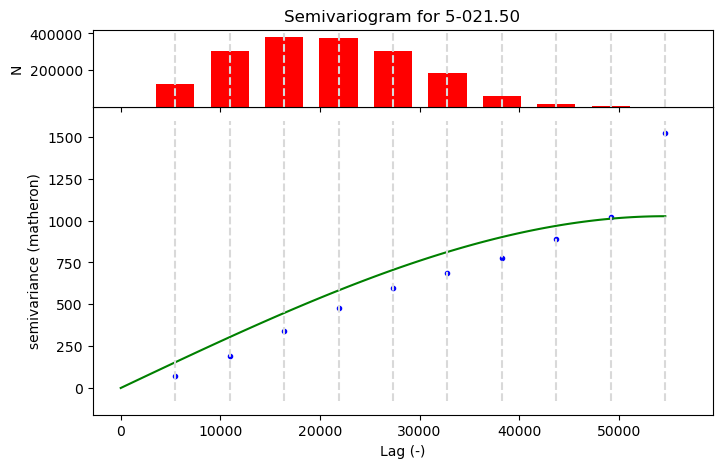

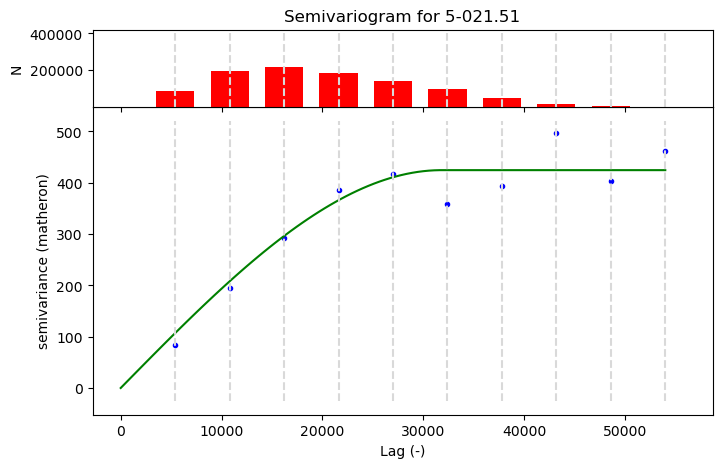

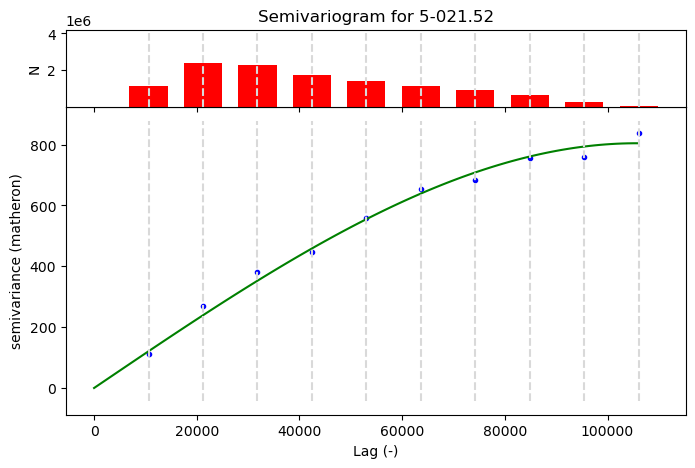

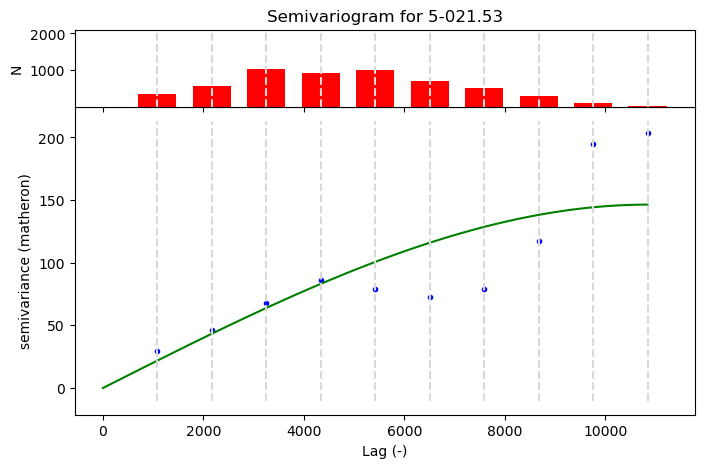

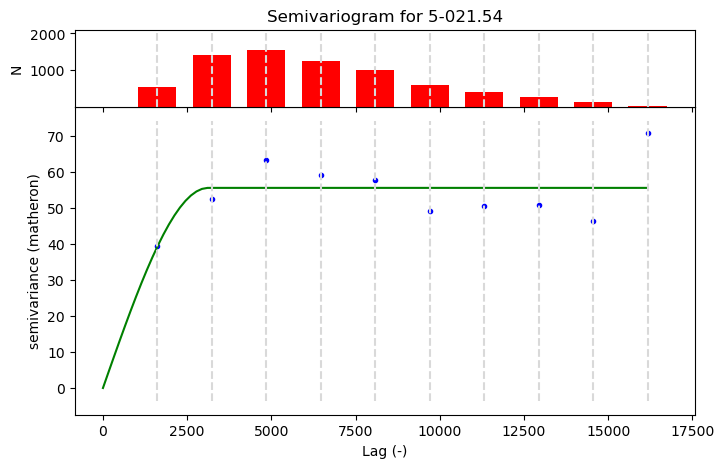

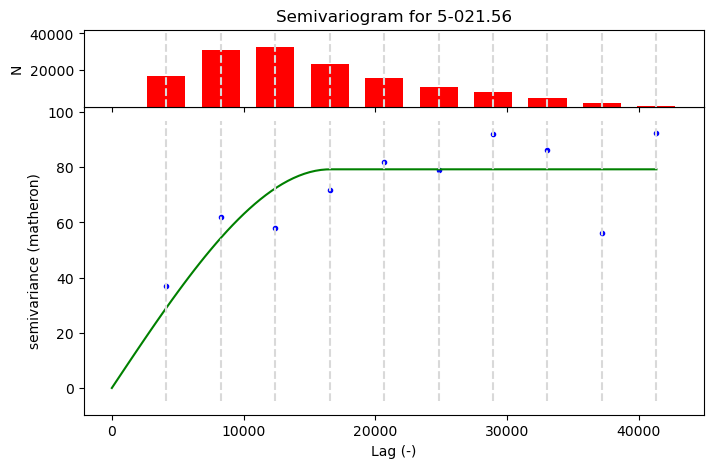

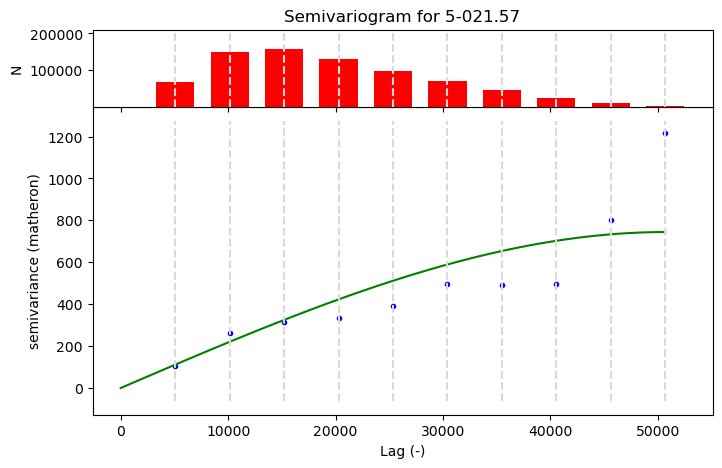

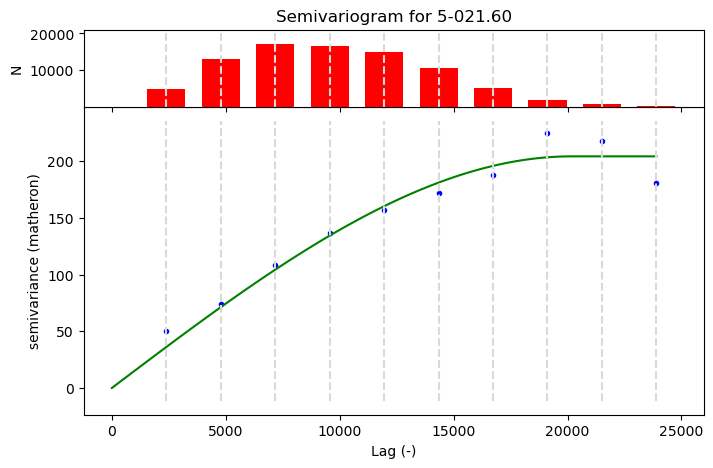

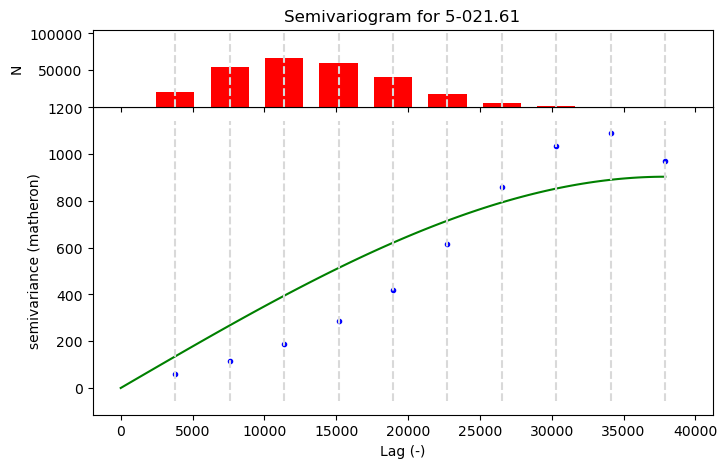

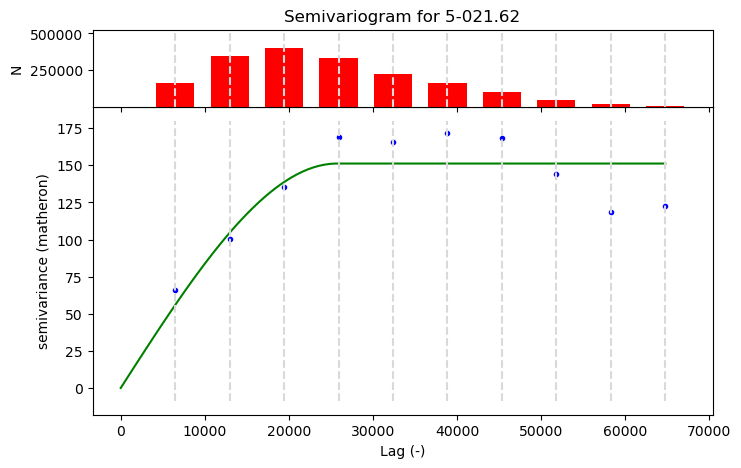

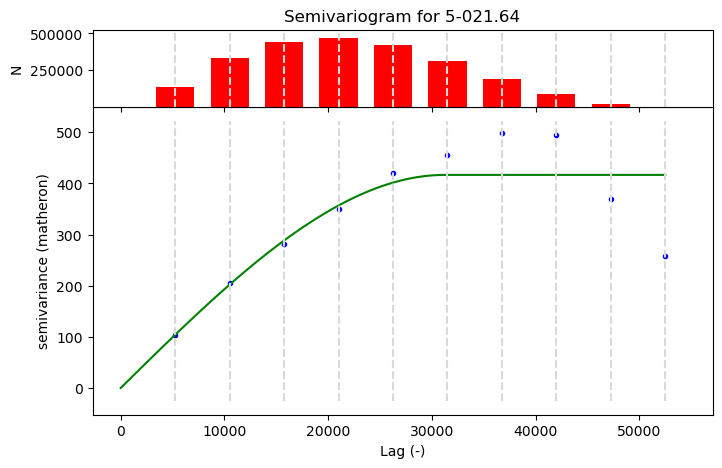

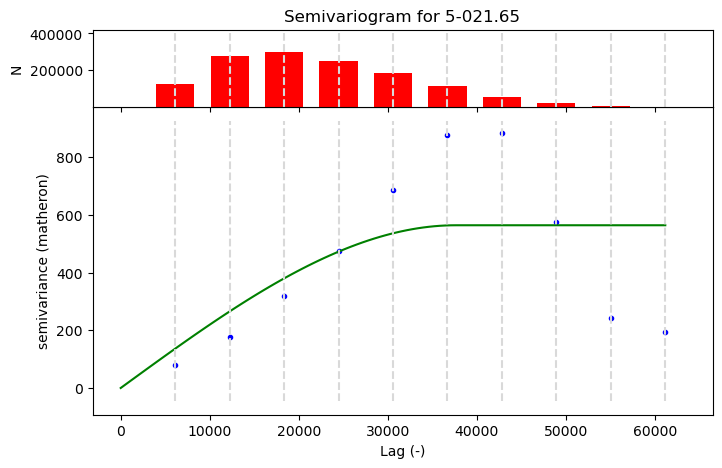

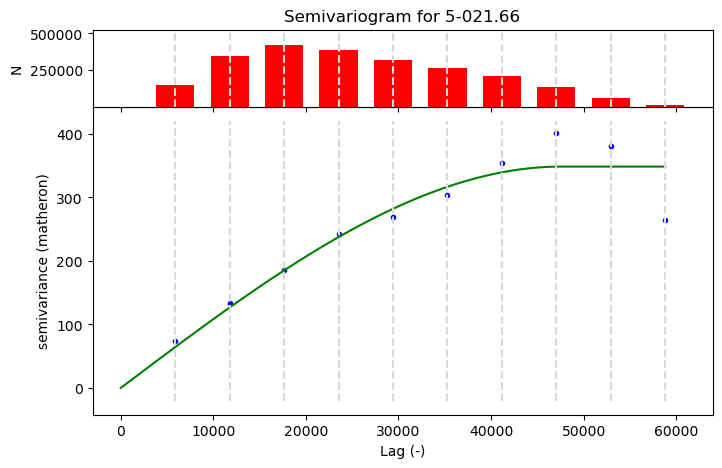

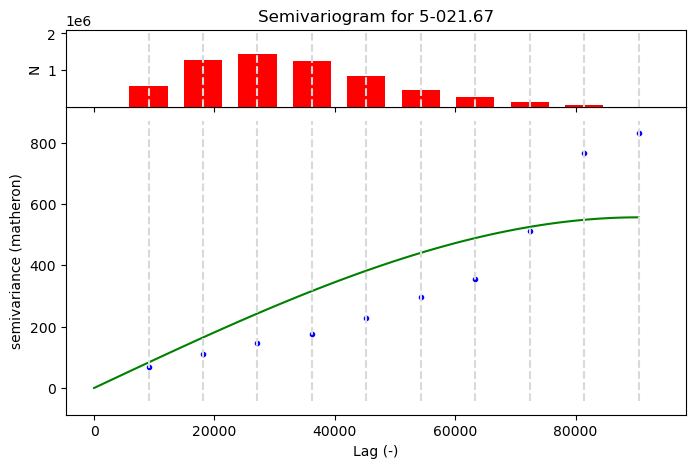

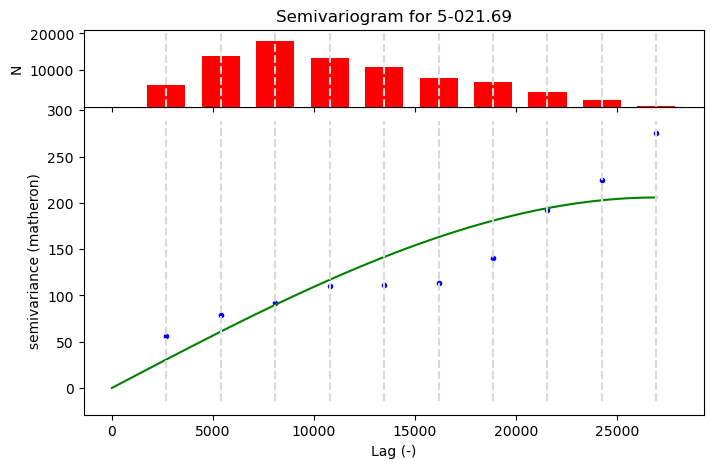

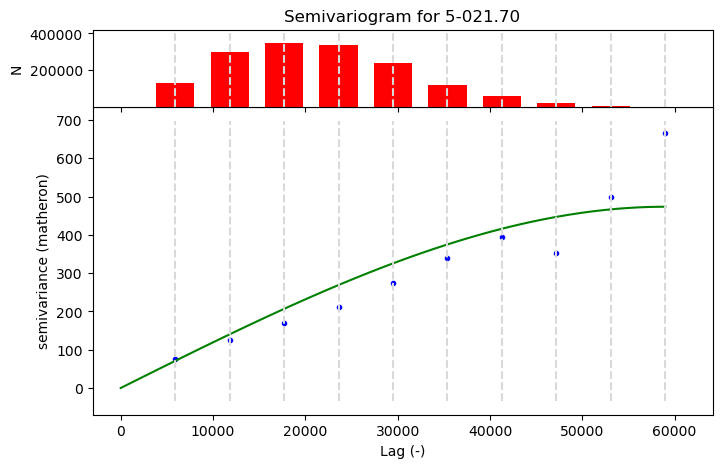

In [37]:
for subb, V in variograms_dict.items():
    fig = V.plot()
    plt.title(f"Semivariogram for {subb}")
    plt.show()

### Now, for $\Delta GWE$

In [56]:
well_trends = pd.read_csv("../data/GWE_trend_by_well.csv")
well_trends = gpd.GeoDataFrame(well_trends, geometry=gpd.points_from_xy(well_trends.longitude, well_trends.latitude))
well_trends = well_trends.set_crs(epsg=4326)

In [65]:
well_trends = well_trends.to_crs(gdf.crs)
well_trends_basin = gpd.sjoin(well_trends, gdf[['Basin_Subb', 'geometry']],
                                how='left', predicate='intersects')
well_trends_basin = well_trends_basin.drop(columns='OBJECTID')
well_trends_basin = well_trends_basin[~well_trends_basin.Basin_Subb.isna()]

In [68]:
year_cols = [col for col in well_trends_basin.columns if col.isdigit()]

In [134]:
yearly_gwe = well_trends_basin[year_cols].to_numpy()
locations = well_trends_basin[["longitude", "latitude"]].to_numpy()
a = SpaceTimeVariogram(coordinates=locations, values=yearly_gwe)

In [184]:
gwe_variograms = {}

for basin in well_trends_basin.Basin_Subb.unique():
    temp = well_trends_basin[well_trends_basin.Basin_Subb == basin].copy()
    if len(temp[["longitude", "latitude"]].value_counts()) < 10:
        continue
    print(f"{basin}: {len(temp)}")
    temp = temp.to_crs("EPSG:3310")
    temp_gwe = temp[year_cols].to_numpy()
    temp_locs = temp[["longitude", "latitude"]].to_numpy()
    gwe_variograms[basin] = SpaceTimeVariogram(coordinates=temp_locs,
                                               values=temp_gwe)

5-021.52: 60
5-021.61: 19
5-021.70: 29
5-021.57: 30
5-021.51: 34


In [209]:
gwe_variograms.get("5-021.52").get_marginal(axis="space")

array([ 94.93952914, 118.38349097, 130.75812896, 110.22090199,
        59.25492823,  89.80089471,  66.11934558,  37.52278633,
        74.16112482,  77.29592206])

In [207]:
gwe_variograms_2014 = {}

for basin in well_trends_basin.Basin_Subb.unique():
    temp = well_trends_basin[well_trends_basin.Basin_Subb == basin].copy()
    if len(temp[["longitude", "latitude"]].value_counts()) < 10:
        continue
    print(f"{basin}: {len(temp)}")
    temp = temp.to_crs("EPSG:3310")
    coords = np.column_stack((temp.geometry.x, temp.geometry.y))
    values = temp['2020'].to_numpy()
    gwe_variograms_2014[basin] = V = Variogram(
        coordinates=coords,
        values=values)

5-021.52: 60
5-021.61: 19
5-021.70: 29
5-021.57: 30
5-021.51: 34


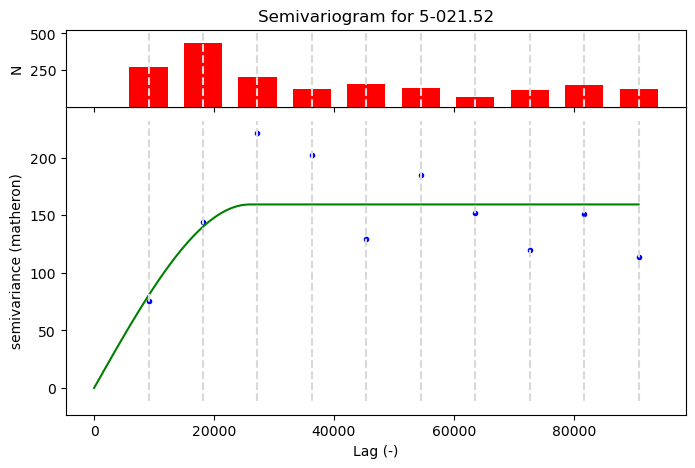

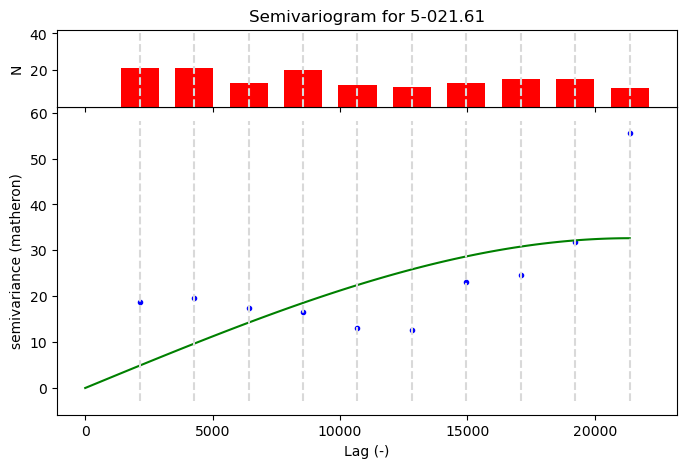

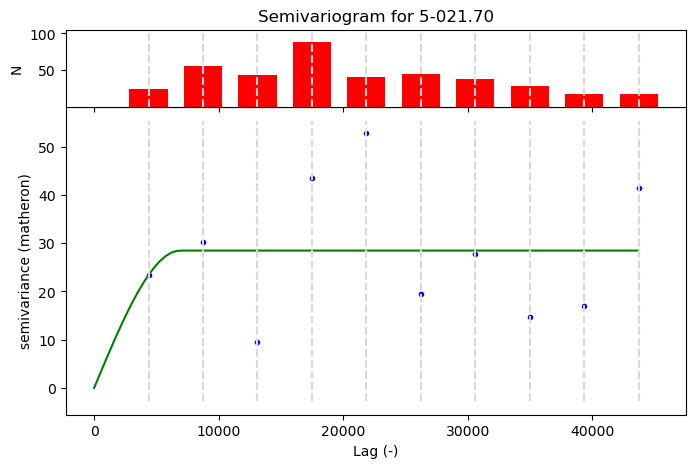

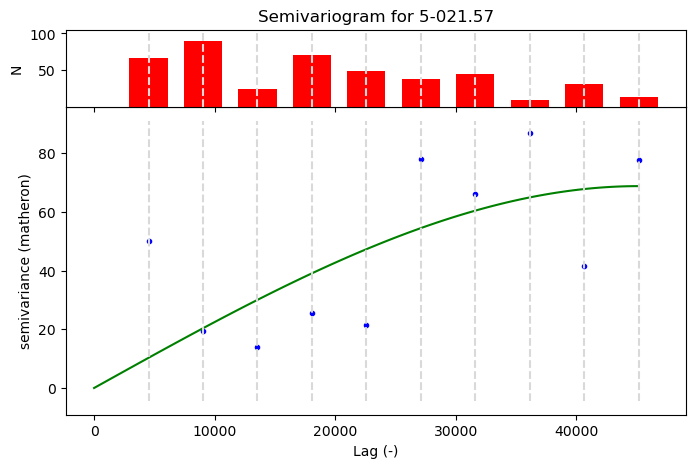

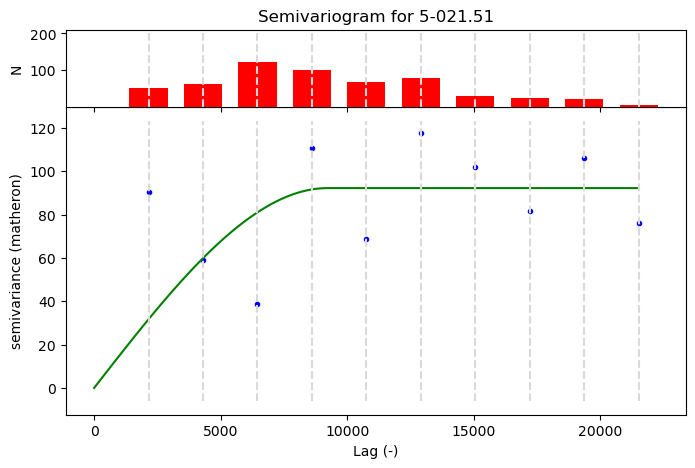

In [208]:
for subb, V in gwe_variograms_2014.items():
    fig = V.plot()
    plt.title(f"Semivariogram for {subb}")
    plt.show()